<a href="https://colab.research.google.com/github/mausumiR/deeplearning/blob/main/ImageCaptioningDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **cnn_rnn_assignment_set_8**

## Group 28
### Mausumi Ratha(2019ab04291)
### Rabindra Kumar Panigrahi(2019ab04143)



## Question:
Image Captioning : Image Captioning is the process of generating textual description of an image. It uses 
both Natural Language Processing and Computer Vision to generate the captions. The dataset will be in the form [image 
→ captions]. The dataset consists of input images and their corresponding output captions

# **1.Import	Libraries/Dataset**

In [ ]:
import pickle
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from collections import Counter



In [ ]:
#Load Data
url = '/content/drive/MyDrive/Colab Notebooks/set_2.pkl'
with open(url, 'rb') as f:
  caption_text = pickle.load(f)

datatxt = []
for text in caption_text :
  for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])
uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())



The number of unique file names : 8021
The distribution of the number of captions for each image:


Counter({1: 525, 2: 1710, 3: 2832, 4: 2211, 5: 743})

In [ ]:
### load the images
dir_jpg = '/content/drive/MyDrive/Colab Notebooks/Flicker8k_Dataset'
jpgs = os.listdir(dir_jpg)
print("The number of jpg flies in Flicker8k_Dataset: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k_Dataset: 8139


# **2.Data	Visualization	and	augmentation**

### a.	Plot	at	least	two	samples	and	their captions

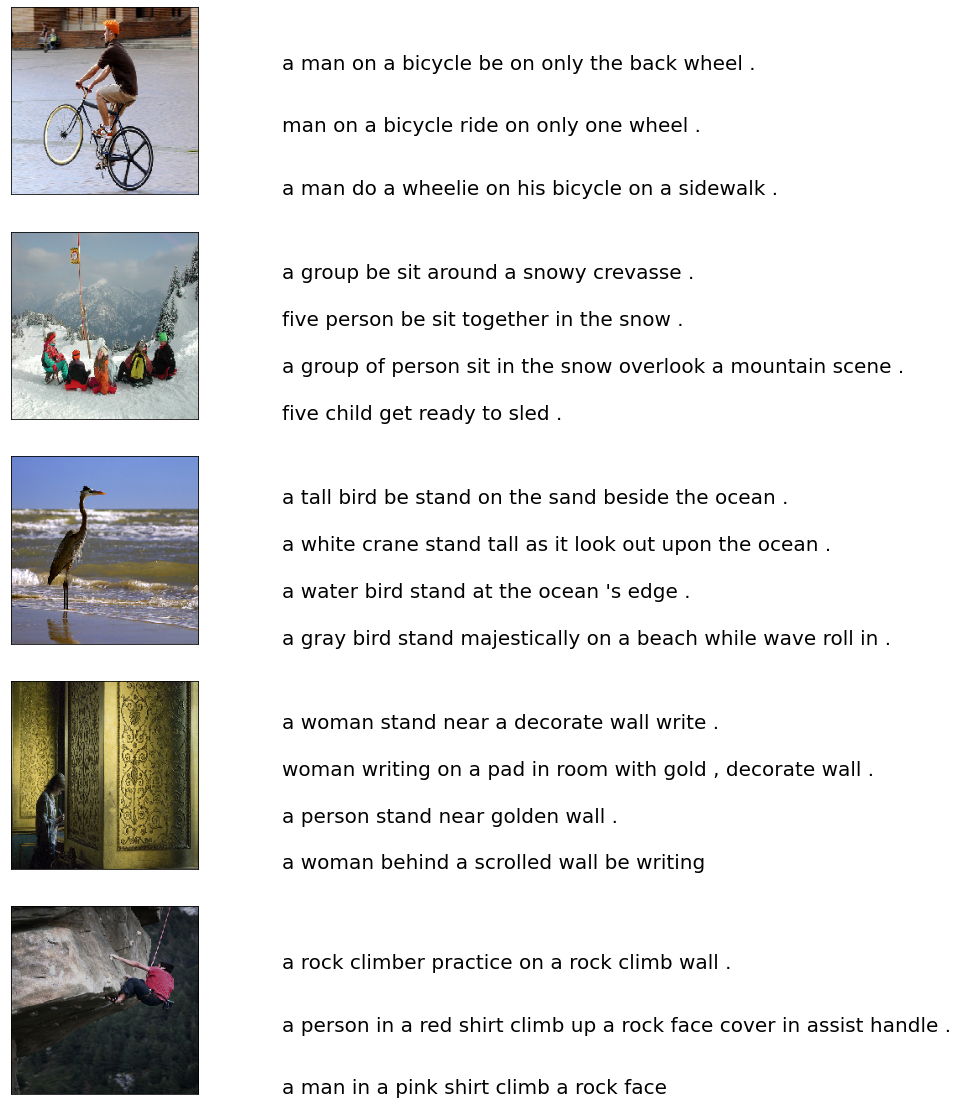

In [ ]:

from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[-npic:]:
    filename = dir_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

### b.	Bring	the	train	and	test	data	in	the	required	format.

## ***Text Preparation***

In [ ]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)


Vocabulary Size: 5588


 ##### Utility to clean the caption


*   remove punctuation
*   remove single character
*   remove numeric






In [ ]:

import string

def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)


def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)


###### clean all captions

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

###### Add startseq and endseq tokens to captions 

In [ ]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt


## ***Image Preparation***
### Extract Freatures of each image using Transfer Learning SqueezeNet



In [ ]:

# from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, Concatenate, \
     MaxPool2D, GlobalAvgPool2D, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file
#from tensorflow.keras.utils import layer_utils


WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

def fire_block(x, squeeze_filters, expand_filters):
    squeezed = Conv2D(filters=squeeze_filters,
                      kernel_size=1,
                      activation='relu')(x)
    expanded_1x1 = Conv2D(filters=expand_filters,
                        kernel_size=1,
                        activation='relu')(squeezed)
    expanded_3x3 = Conv2D(filters=expand_filters,
                        kernel_size=3,
                        padding='same',
                        activation='relu')(squeezed)

    output = Concatenate()([expanded_1x1, expanded_3x3])
    return output

# def SqueezeNet(include_top=True, weights='imagenet',
#                input_tensor=None, input_shape=None,
#                pooling=None,
#                classes=1000):
 
        
#     if weights not in {'imagenet', None}:
#         raise ValueError('The `weights` argument should be either '
#                          '`None` (random initialization) or `imagenet` '
#                          '(pre-training on ImageNet).')

#     if weights == 'imagenet' and classes != 1000:
#         raise ValueError('If using `weights` as imagenet with `include_top`'
#                          ' as true, `classes` should be 1000')


#     # input_shape = _obtain_input_shape(input_shape,
#     #                                   default_size=227,
#     #                                   min_size=48,
#     #                                   data_format=K.image_data_format(),
#     #                                   require_flatten=include_top)

#     # if input_tensor is None:
#     #     img_input = Input(shape=input_shape)
#     # else:
#     #     if not K.is_keras_tensor(input_tensor):
#     #         img_input = Input(tensor=input_tensor, shape=input_shape)
#     #     else:
#     #         img_input = input_tensor


#     input = Input([224, 224, 3])

#     x = Conv2D(96, 7, strides=2, padding='same', activation='relu')(input)
#     x = MaxPool2D(3, strides=2, padding='same')(x)


#     x = fire_block(x, squeeze_filters=16, expand_filters=64)
#     x = fire_block(x, squeeze_filters=16, expand_filters=64)
#     x = fire_block(x, squeeze_filters=32, expand_filters=128)
#     x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

#     x = fire_block(x, squeeze_filters=32, expand_filters=128)
#     x = fire_block(x, squeeze_filters=48, expand_filters=192)
#     x = fire_block(x, squeeze_filters=48, expand_filters=192)
#     x = fire_block(x, squeeze_filters=64, expand_filters=256)
#     x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)

#     x = fire_block(x, squeeze_filters=64, expand_filters=256)
    
#     if include_top:
#         # It's not obvious where to cut the network... 
#         # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
#         x = Dropout(0.5, name='drop9')(x)
#         x = Conv2D(filters=1000, kernel_size=1)(x)
#         output = GlobalAvgPool2D()(x)
#     else:
#         if pooling == 'avg':
#             output = GlobalAveragePooling2D()(x)
#         elif pooling=='max':
#             output = GlobalMaxPooling2D()(x)
#         elif pooling==None:
#             pass
#         else:
#             raise ValueError("Unknown argument for 'pooling'=" + pooling)

#     # Ensure that the model takes into account
#     # any potential predecessors of `input_tensor`.
#     # if input_tensor is not None:
#     #     inputs = get_source_inputs(input_tensor)
#     # else:
#     #     inputs = img_input

#     model = Model(input, x, name='squeezenet')

#     # load weights
#     if weights == 'imagenet':
#         if include_top:
#             weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
#                                     WEIGHTS_PATH,
#                                     cache_subdir='models')
#         else:
#             weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
#                                     WEIGHTS_PATH_NO_TOP,
#                                     cache_subdir='models')
            
#         model.load_weights(weights_path)
#         # if K.backend() == 'theano':
#         #     layer_utils.convert_all_kernels_in_model(model)

#         if K.image_data_format() == 'channels_first':

#             if K.backend() == 'tensorflow':
#                 warnings.warn('You are using the TensorFlow backend, yet you '
#                               'are using the Theano '
#                               'image data format convention '
#                               '(`image_data_format="channels_first"`). '
#                               'For best performance, set '
#                               '`image_data_format="channels_last"` in '
#                               'your Keras config '
#                               'at ~/.keras/keras.json.')
#     return model

In [ ]:
 
input = Input([224, 224, 3])
 
x = Conv2D(64, 3, strides=2, padding='same', activation='relu')(input)
x = MaxPool2D(3, strides=2, padding='same')(x)
 
 
x = fire_block(x, squeeze_filters=16, expand_filters=64)
x = fire_block(x, squeeze_filters=16, expand_filters=64)
x = fire_block(x, squeeze_filters=32, expand_filters=128)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
 
x = fire_block(x, squeeze_filters=32, expand_filters=128)
x = fire_block(x, squeeze_filters=48, expand_filters=192)
x = fire_block(x, squeeze_filters=48, expand_filters=192)
x = fire_block(x, squeeze_filters=64, expand_filters=256)
x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
 
x = fire_block(x, squeeze_filters=64, expand_filters=256)
 
 
x = Conv2D(filters=1000, kernel_size=1)(x)
output = GlobalAvgPool2D()(x)
 
#output = Activation('softmax')(x)
 
from tensorflow.keras import Model
model = Model(input, output)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                     WEIGHTS_PATH,
                                     cache_subdir='models')
# initiate RMSprop optimizer
opt = RMSprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.load_weights(weights_path)
loss_history = []
model.summary()




5062656/5059384 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 56, 56, 16)   1040        max_pooling2d[0][0]              
_______________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Helper function to process images
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from collections import OrderedDict
import numpy as np
images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))

for i,name in enumerate(jpgs):
    
    if i%1000==0:
        print(i)
    if(i>=5000):
      break
    # load an image from file
    filename = dir_jpg + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    #nimage = preprocess_input(image)    
    y_pred = model.predict(image)
    images[name] = y_pred.flatten()
  


0
1000
2000
3000
4000
5000
6000
7000
8000


## **Link the text and image data**

In [ ]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)

In [ ]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 8000
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 2686
[[1, 127, 42, 182, 7, 87, 512, 2], [1, 16, 6, 15, 5, 4, 19, 54, 147, 130, 2], [1, 29, 51, 3, 186, 6, 27, 212, 51, 3, 13, 2], [1, 5, 589, 7, 25, 138, 3, 8, 43, 64, 22, 82, 5, 47, 7, 2], [1, 12, 42, 25, 75, 54, 27, 1466, 79, 17, 187, 2]]


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


## **Split between training and testing data**

In [ ]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
maxlen = np.max([len(text) for text in dtexts])

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 3013


In [ ]:
from keras import layers
print(vocab_size)
## image feature

dim_embedding = 64

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = Model(inputs=[input_image, input_txt],outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

In [ ]:
# fit model
import time
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

In [ ]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

### Validation loss and training loss over epochs

In [ ]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## **Prediction**

In [ ]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[npic:npic]):
    ## images 
    filename = dir_jpg + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()